# 3D Protein Pose Recovery - Robustness to Unseen Protein

Through the following model, we consider that a cryo-EM measurement (i.e. 2D projection) $\mathbf{y}_i \in \mathbb{R}^{M}$ is acquired through
\begin{equation}
\label{eq:linear-forward-model}
\mathbf{y}_i={\mathbf {C}_{\boldsymbol\varphi}}\mathbf S_{\mathbf{t}}\mathbf P_{\theta_i}\mathbf x+\mathbf n,
\end{equation}
where $\mathbf x \in \mathbb{R}^{V}$ is the unknown 3D density map [*DiMaio et al.*](https://academic.oup.com/bioinformatics/article/23/21/2851/374177) (Coulomb potential). The operator $\mathbf P_{\theta_i}: \mathbb R^V \to \mathbb R^M$ is the projection along the 3D pose $\theta_i$ (i.e., the x-ray transform). The operator $\mathbf S_\mathbf{t}: \mathbb R^M \to \mathbb R^M$ is a shift of the projection by $\mathbf{t}=(t_1, t_2)$. The convolution operator $\mathbf {C}_{\boldsymbol\varphi}: \mathbb R^M \to \mathbb R^M$ models the microscope contrast transfer function (CTF) with parameters $\boldsymbol\varphi=(d_1, d_2, \alpha_{\rm ast})$, that are, respectively, the defocus-major, the defocus-minor and the angle of astigmatism. Finally, $\mathbf n \in \mathbb{R}^{M}$ represents an additive noise. Our goal is then to recover the angles $\theta_i$ from every projection $\mathbf y_i$. 

Final **goal**: We have $N$ protein 3D volumes that are used to create the training set of 2D projections $\{\mathbf y_{N, i}^{train}\}$. Another, unseen protein 3D volume $\mathbf x^{test}$ is used to create the test set of 2D projections $\{\mathbf y_i^{test}\}$. The set of projections is created using the projection $\mathbf P_{\theta_i}$ along the 3D pose $\theta_i$ as well as all the other operators (noise $\mathbf n$, CTF $\mathbf C_\varphi$, shift $\mathbf S_{\mathbf t}$) specified in the equation above. 


  $\{\mathbf x_1^{train}, ..., \mathbf x_N^{train}\}  \rightarrow \{\mathbf y_{N, i}^{train}\} = \{{\mathbf {C}_{\boldsymbol\varphi}}\mathbf S_{\mathbf{t}}\mathbf P_{\theta_i}\mathbf x_N^{train}+\mathbf n\}$
  

  $\mathbf x^{test} \rightarrow \{\mathbf y_i^{test}\} =\{{\mathbf {C}_{\boldsymbol\varphi}}\mathbf S_{\mathbf{t}}\mathbf P_{\theta_i}\mathbf x^{test}+\mathbf n\}$

In [1]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import sys
sys.path.append("..") 
from cryoem.projections import generate_2D_projections
from cryoem.plots import plot_projection, plot_detector_pixels, plot_angles_count
from cryoem.preprocessing import preprocessing, train_val_test_split
from cryoem.distance_estimation import train_distance_estimation
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl
from cryoem.conversions import quaternion2euler
import matplotlib.pyplot as plt
from cryoem.conversions import d_q, euler2quaternion
from cryoem.reconstruction import reconstruct
from cryoem.plots import plot_dP_dQ
import h5py
import ipyvolume as ipv
import numpy as np
import pathlib
import tensorflow as tf
from tensorflow.python.client import device_lib 
# from numba import cuda
tf.__version__

'2.0.0'

In [3]:
!echo $CUDA_VISIBLE_DEVICES

0


In [4]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2400681609792446528
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17199326056919964016
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6275281157544657168
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3869638656
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2876543308410997785
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [5]:
!which python

/home/jelena/miniconda3/envs/protein_reconstruction/bin/python


## (1) Generate Sythetic Data

In [6]:
MRC_DIR         = "/home/jelena/MRC"  #"/mnt/scratch/students/MRC"
RESULTS_DIR     = "/home/jelena/data"  #"/mnt/scratch/students"
pathlib.Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)

In [7]:
NUM_TRAIN_PROTEINS = 3
NUM_TEST_PROTEINS  = 2

In [8]:
PROTEINS  = ['2cse.mrc',
             '4bed.mrc',
             '5iou.mrc',
             '5a1a.mrc',
             '5j0n.mrc',
             
             #'5o5b.mrc',
             #'5t4p.mrc',
             '6buz.mrc',
             '6lz1.mrc',
             #'6psf.mrc',
             '6qee.mrc',
             '6rd5.mrc',
             '6re5.mrc',
             '6sjl.mrc',
             '6vkn.mrc',
             '6w4o.mrc',
             '6wbk.mrc',
             '6xe0.mrc',
             '7c79.mrc']
PROTEINS = list(map(lambda x: x[:-4], PROTEINS))
PROTEINS_TRAIN = PROTEINS[:NUM_TRAIN_PROTEINS]
PROTEINS_TEST  = PROTEINS[NUM_TRAIN_PROTEINS:NUM_TRAIN_PROTEINS+NUM_TEST_PROTEINS]

In [9]:
# 2.0, 1.0, 0.5 - 1/4
# 2.0, 1.0, 2.0 - 1
# 2.0, 1.0, 1.0 - 1/2

In [10]:
PROJECTIONS_NUM_SINGLE = 1000
# ang1, ang2, ang3(=inplane rotation)
ANGLE_COVERAGE         = [2.0, 1.0, 2.0]  #[1.8, 0.5, 2.]  #[1.9, 0.9, 1.0]
ANGLE_SHIFT            = [0., 0.,  0.]#[0.1, 0., 0.]

In [11]:
PROTEINS_TRAIN + PROTEINS_TEST

['2cse', '4bed', '5iou', '5a1a', '5j0n']

In [12]:
IMG_DIM = 64
NOISE_VAR_SCALE = 0   # it takes max px value to be the variance, since all proteins have it different
TRANSLATION = 0
CHANNELS = 1
DTYPE = np.float16

In [13]:

"""""
@author: fangshu.yang@epfl.ch, laurene.donati@epfl.ch 
"""

import numpy as np
import random
import os, sys
import scipy.io as sio
sys.path.append(os.getcwd())
import time
import mrcfile
import skimage
from skimage import transform
import matplotlib.pyplot as plt
import astra
import pathlib
import h5py
from cryoem.rotation_matrices import RotationMatrix

 
def gen_projs_ASTRA(Vol, AngCoverage, AngShift, angles, ProjSize, BatchSizeAstra, angles_gen_mode="uniform_angles"):
    """
    angles_gen_mode: str
        Takes values in [`uniform_angles`, `uniform_quaternions`]
    """
    # Create 3D geometry in ASTRA
    Vol_geom    = astra.create_vol_geom(Vol.shape[1], Vol.shape[2], Vol.shape[0])

    # Generate random angles
    if angles_gen_mode == "uniform_angles":
        Z1 =  AngShift[0]*np.pi + AngCoverage[0]*np.pi*np.random.random(size=(BatchSizeAstra, 1))
        Y2 =  AngShift[1]*np.pi + AngCoverage[1]*np.pi*np.random.random(size=(BatchSizeAstra, 1))
        Z3 =  AngShift[2]*np.pi + AngCoverage[2]*np.pi*np.random.random(size=(BatchSizeAstra, 1))
        angles = np.concatenate((Z1, Y2, Z3), axis=1)
    elif angles_gen_mode == "uniform_S3":
        quaternions = quaternion.normalized_random_uniform(quaternion_shape=(BatchSizeAstra,))
        quaternions = quaternions  #[:BatchSizeAstra]
        angles = quaternion2euler(quaternions)
        
#         indices = np.where((AngShift[0]*np.pi<=angles[:,0]) & (angles[:,0]<=AngCoverage[0]*np.pi) & ((AngShift[1]*np.pi<=angles[:,1]) & (angles[:,1]<=AngCoverage[1]*np.pi) & (AngShift[2]*np.pi<=angles[:,2]) & (angles[:,2]<=AngCoverage[2]*np.pi)))[0]
#         angles = np.take(angles, indices, axis=0)

#         phi = 2*np.pi*np.random.random(size=(BatchSizeAstra, 1))
#         cos_theta = 2*np.random.random(size=(BatchSizeAstra, 1))-1
#         u = np.random.random(size=(BatchSizeAstra, 1))
#         theta = np.arccos(cos_theta)
#         r = np.cbrt(u)

#         phi = AngShift[2]*np.pi + AngCoverage[2]**np.pi*np.random.random(size=(BatchSizeAstra, 1))
#         min_v = min(np.cos(AngShift[1]*np.pi), np.cos(AngShift[1]*np.pi+AngCoverage[1]*np.pi))
#         max_v = max(np.cos(AngShift[1]*np.pi), np.cos(AngShift[1]*np.pi+AngCoverage[1]*np.pi))
#         cos_theta = np.random.uniform(low=min_v, high=max_v, size=(BatchSizeAstra, 1))
#         u = np.random.random(size=(BatchSizeAstra, 1))
#         theta = np.arccos(cos_theta)
#         # TODO: left to limit r
#         r = np.cbrt(u)
#         angles = np.concatenate((r, theta, phi), axis=1)
    elif angles_gen_mode == "given":
        if angles is None:
            raise Exception("Please pass the angles")
    else:
        raise NotImplemented("Please specify angles_gen_mode parameter that represents how angles will be generated")
    
    # Generate orientation vectors based on angles
    Orientation_Vectors   = RotationMatrix(angles)

    # Create projection 2D geometry in ASTRA
    Proj_geom = astra.create_proj_geom('parallel3d_vec', ProjSize, ProjSize, Orientation_Vectors)

    # Generate projs 
    _, Proj_data = astra.create_sino3d_gpu(Vol, Proj_geom, Vol_geom)

    # Reshape projections correctly 
    Projections = np.transpose(Proj_data, (1, 0, 2))

    return Projections, angles


def generate_2D_projections(input_file_path, ProjNber, AngCoverage, AngShift, angles_true, angles_gen_mode=None, output_file_name=None, dtype=np.float32):
    """
    input_file_path: str
        Full path to the *.mrc file with 3D volume
    ProjNber: int
        Number of 2D projections 
    AngCoverage: list
        list of max values for each axis. E.g. `0.5,0.5,2.0` means it: x axis angle and y axis angle take values in range [0, 0.5*pi], z axis angles in range [0, 2.0*pi]
    AngShift: list
        Start of angular coverage
	angles_gen_mode: str
		2 options: (1) generate angles uniformly in angle space - 'uniform_angles', and (2) generate angles uniformly in quaternion space - 'uniform_S3'
    output_file_name: str
        Just the name of the output *.mat file. 
        If not specified, it will be generated automatically.
    """
    # nber of projs created in a single ASTRA loop
    BatchSizeAstra = 50 

    # filepaths 
    protein_name = input_file_path.split('/')[-1].split('.')[0]
    if angles_gen_mode != 'given':
        coverage_str = str(AngCoverage).replace(" ", "")[1:-1]
        shift_str    = str(AngShift).replace(" ", "")[1:-1]
        output_file_name = output_file_name or f'{protein_name}_ProjectionsAngles_ProjNber{ProjNber}_AngCoverage{coverage_str}_AngShift{shift_str}.h5'
    else:
        output_file_name = output_file_name or f'{protein_name}_Mode{angles_gen_mode}.h5'
    # get file extension
    extension = output_file_name.split('.')[-1]
    # storing output where the input mrc file is
    proj_ang_path = os.path.join(os.path.dirname(input_file_path), output_file_name)

    # loads data if data already exists 
    if os.path.exists(proj_ang_path):
        print('* Loading the dataset *\n')

        # read from the file
        if extension == "h5":
            with h5py.File(proj_ang_path, 'r') as data:
                Projections = dtype(data['Projections'])
                Angles      = dtype(data['Angles'])
        elif extension == "mat":
            with sio.loadmat(proj_ang_path) as data:
                Projections = dtype(data['Projections'])
                Angles      = dtype(data['Angles'])
        else: 
            raise NotImplementedError(f"Extension {extension} is not implemented")
    # generate data if data doesn't exist  
    else:
        print('* Generating the dataset *\n')

        # Load 3D volume
        # Value error fix explained here: https://mrcfile.readthedocs.io/en/latest/usage_guide.html 
        try:
            with mrcfile.open(input_file_path) as mrcVol:
                Vol      = np.array(mrcVol.data) 
                ProjSize = int(np.sqrt(np.sum(np.square(Vol.shape))))
        except ValueError:
            with mrcfile.open(input_file_path, mode='r+', permissive=True) as mrcVol:
                mrcVol.header.map = mrcfile.constants.MAP_ID
                Vol      = np.array(mrcVol.data) 
                ProjSize = int(np.sqrt(np.sum(np.square(Vol.shape))))

        # Initialisations 
        Projections = np.zeros((ProjNber, ProjSize, ProjSize), dtype=dtype)
        Angles      = np.zeros((ProjNber, 3), dtype=dtype)

        # Generate projs with ASTRA by batches 
        Iter = int(ProjNber/BatchSizeAstra) 
        for i in range(Iter):

            # Generate projections 
            projections, angles = gen_projs_ASTRA(Vol, AngCoverage, AngShift, angles_true[i*BatchSizeAstra : (i + 1)*BatchSizeAstra], ProjSize, BatchSizeAstra, angles_gen_mode)

            # Concatenate generated projections 
            Projections[i*BatchSizeAstra : (i + 1)*BatchSizeAstra, :, :] = projections
            Angles[i*BatchSizeAstra : (i + 1)*BatchSizeAstra, :] = angles  

        # Save data 
        if extension == "h5":
            with h5py.File(proj_ang_path, 'w') as hf:
                hf.create_dataset('Projections', data=Projections)
                hf.create_dataset('Angles', data=Angles)
        elif extension == "mat":
            sio.savemat(proj_ang_path, {'Projections': Projections, 
                                        'Angles': Angles}) 
        else:
            raise NotImplementedError(f"Extension {extension} is not implemented")

    print(f'Projections: {Projections.shape}')
    print(f'Angles: {Angles.shape}\n')


In [14]:
# generate sythetic data - 2D projections and their corresponding orientations from a given 3D protein
for protein in PROTEINS_TRAIN + PROTEINS_TEST: 
    generate_2D_projections(input_file_path=f"{MRC_DIR}/{protein}.mrc", 
                            ProjNber=PROJECTIONS_NUM_SINGLE,
                            AngCoverage=None, #ANGLE_COVERAGE,
                            AngShift=None, #ANGLE_SHIFT,
                            angles_true=np.load(f"{RESULTS_DIR}/custom_true_angles.npy"),
                            angles_gen_mode="given",
                            output_file_name=f"{RESULTS_DIR}/{protein}_ProjectionsAngles_ProjNber{PROJECTIONS_NUM_SINGLE}_AngCoverage{','.join(map(str, ANGLE_COVERAGE))}_AngShift{','.join(map(str, ANGLE_COVERAGE))}.h5",
                            dtype=DTYPE)
    #cuda.current_context().reset() 

* Loading the dataset *

Projections: (1000, 909, 909)
Angles: (1000, 3)

* Loading the dataset *

Projections: (1000, 907, 907)
Angles: (1000, 3)

* Loading the dataset *

Projections: (1000, 573, 573)
Angles: (1000, 3)

* Loading the dataset *

Projections: (1000, 275, 275)
Angles: (1000, 3)

* Loading the dataset *

Projections: (1000, 116, 116)
Angles: (1000, 3)



In [15]:
IMG_DIM = 64
NOISE_VAR_SCALE = 0   # it takes max px value to be the variance, since all proteins have it different
TRANSLATION = 0
CHANNELS = 1
DTYPE = np.float16

In [16]:
# # read stored data for further processing
# projections_train = []  #np.empty((len(PROTEINS_TRAIN)*PROJECTIONS_NUM_SINGLE, IMG_DIM, IMG_DIM, CHANNELS), dtype=DTYPE)
# angles_true_train = []  #np.empty((len(PROTEINS_TRAIN)*PROJECTIONS_NUM_SINGLE, 3), dtype=DTYPE)

# print(f"* Train dataset *")
# for i, protein in enumerate(PROTEINS_TRAIN):
#     data = h5py.File(f"{RESULTS_DIR}/{protein}_ProjectionsAngles_ProjNber{PROJECTIONS_NUM_SINGLE}_AngCoverage{','.join(map(str, ANGLE_COVERAGE))}_AngShift{','.join(map(str, ANGLE_COVERAGE))}.h5", 'r')
#     projections = np.array(data['Projections'])
#     angles_true = np.array(data['Angles'])
    
#     print(f"--- protein: {protein} ---")
#     print(f"{projections.shape[0]} projections of images with dimension {projections.shape[1:]} pixels")
#     print(f"{angles_true.shape[0]} sets of {angles_true.shape[1]} ground truth rotation angles (Z-Y-Z axes) of corresponding projection images")

#     projections = preprocessing(projections, rescale_dim=IMG_DIM, noise_var_scale=NOISE_VAR_SCALE, left_limit=-TRANSLATION, peak_limit=0, right_limit=TRANSLATION, channels=CHANNELS)
   
#     projections_train.extend(projections)
#     angles_true_train.extend(angles_true)

# projections_test = []  #np.empty((len(PROTEINS_TEST)*PROJECTIONS_NUM_SINGLE, IMG_DIM, IMG_DIM, CHANNELS), dtype=DTYPE)
# angles_true_test = []  #np.empty((len(PROTEINS_TEST)*PROJECTIONS_NUM_SINGLE, 3), dtype=DTYPE)

# print(f"\n* Test dataset *")
# for i, protein in enumerate(PROTEINS_TEST):
#     data = h5py.File(f"{RESULTS_DIR}/{protein}_ProjectionsAngles_ProjNber{PROJECTIONS_NUM_SINGLE}_AngCoverage{','.join(map(str, ANGLE_COVERAGE))}_AngShift{','.join(map(str, ANGLE_COVERAGE))}.h5", 'r')
#     projections = np.array(data['Projections'])
#     angles_true = np.array(data['Angles'])
    
#     print(f"--- protein: {protein} ---")
#     print(f"{projections.shape[0]} projections of images with dimension {projections.shape[1:]} pixels")
#     print(f"{angles_true.shape[0]} sets of {angles_true.shape[1]} ground truth rotation angles (Z-Y-Z axes) of corresponding projection images")
    
#     projections = preprocessing(projections, rescale_dim=IMG_DIM, noise_var_scale=NOISE_VAR_SCALE, left_limit=-TRANSLATION, peak_limit=0, right_limit=TRANSLATION, channels=CHANNELS)
    
#     projections_test.extend(projections)
#     angles_true_test.extend(angles_true)
    

In [17]:
# projections_train = np.array(projections_train).astype(DTYPE)
# angles_true_train = np.array(angles_true_train).astype(DTYPE)

# projections_test = np.array(projections_test).astype(DTYPE)
# angles_true_test = np.array(angles_true_test).astype(DTYPE)

In [18]:
# read stored data for further processing
projections_train = np.empty((len(PROTEINS_TRAIN)*PROJECTIONS_NUM_SINGLE, IMG_DIM, IMG_DIM, CHANNELS), dtype=DTYPE)
angles_true_train = np.empty((len(PROTEINS_TRAIN)*PROJECTIONS_NUM_SINGLE, 3), dtype=DTYPE)

print(f"* Train dataset *")
for i, protein in enumerate(PROTEINS_TRAIN):
    data = h5py.File(f"{RESULTS_DIR}/{protein}_ProjectionsAngles_ProjNber{PROJECTIONS_NUM_SINGLE}_AngCoverage{','.join(map(str, ANGLE_COVERAGE))}_AngShift{','.join(map(str, ANGLE_COVERAGE))}.h5", 'r')
    projections = np.array(data['Projections'], dtype=np.float32)
    if np.min(projections) - np.max(projections) == 0: 
        PROTEINS_TRAIN.remove(protein)
        continue
    angles_true = np.array(data['Angles'], dtype=np.float32)
    if np.isnan(angles_true).any() or (np.min(angles_true) - np.max(angles_true) == 0): 
        PROTEINS_TRAIN.remove(protein)
        continue
    
    print(f"--- protein: {protein} ---")
    print(f"{projections.shape[0]} projections of images with dimension {projections.shape[1:]} pixels")
    print(f"{angles_true.shape[0]} sets of {angles_true.shape[1]} ground truth rotation angles (Z-Y-Z axes) of corresponding projection images")

    projections = preprocessing(projections, rescale_dim=IMG_DIM, noise_var_scale=NOISE_VAR_SCALE, left_limit=-TRANSLATION, peak_limit=0, right_limit=TRANSLATION, channels=CHANNELS)
   
    projections_train[i*PROJECTIONS_NUM_SINGLE:(i+1)*PROJECTIONS_NUM_SINGLE] = projections.astype(DTYPE)
    angles_true_train[i*PROJECTIONS_NUM_SINGLE:(i+1)*PROJECTIONS_NUM_SINGLE] = angles_true.astype(DTYPE)

projections_test = np.empty((len(PROTEINS_TEST)*PROJECTIONS_NUM_SINGLE, IMG_DIM, IMG_DIM, CHANNELS), dtype=DTYPE)
angles_true_test = np.empty((len(PROTEINS_TEST)*PROJECTIONS_NUM_SINGLE, 3), dtype=DTYPE)

print(f"\n* Test dataset *")
for i, protein in enumerate(PROTEINS_TEST):
    data = h5py.File(f"{RESULTS_DIR}/{protein}_ProjectionsAngles_ProjNber{PROJECTIONS_NUM_SINGLE}_AngCoverage{','.join(map(str, ANGLE_COVERAGE))}_AngShift{','.join(map(str, ANGLE_COVERAGE))}.h5", 'r')
    projections = np.array(data['Projections'], dtype=np.float32)
    print(np.min(projections) - np.max(projections))
    if np.isnan(projections).any() or (np.min(projections) - np.max(projections) == 0): 
        PROTEINS_TEST.remove(protein)
        continue
    angles_true = np.array(data['Angles'], dtype=np.float32)
    if np.isnan(angles_true).any() or (np.min(angles_true) - np.max(angles_true) == 0): 
        PROTEINS_TEST.remove(protein)
        continue
    
    print(f"--- protein: {protein} ---")
    print(f"{projections.shape[0]} projections of images with dimension {projections.shape[1:]} pixels")
    print(f"{angles_true.shape[0]} sets of {angles_true.shape[1]} ground truth rotation angles (Z-Y-Z axes) of corresponding projection images")
    
    projections = preprocessing(projections, rescale_dim=IMG_DIM, noise_var_scale=NOISE_VAR_SCALE, left_limit=-TRANSLATION, peak_limit=0, right_limit=TRANSLATION, channels=CHANNELS)
    
    projections_test[i*PROJECTIONS_NUM_SINGLE:(i+1)*PROJECTIONS_NUM_SINGLE] = projections.astype(DTYPE)
    angles_true_test[i*PROJECTIONS_NUM_SINGLE:(i+1)*PROJECTIONS_NUM_SINGLE] = angles_true.astype(DTYPE)

* Train dataset *
--- protein: 2cse ---
1000 projections of images with dimension (909, 909) pixels
1000 sets of 3 ground truth rotation angles (Z-Y-Z axes) of corresponding projection images
Preprocessing projections
	Image rescaled: 
		from dimension 909 to 64
	Global standardization
		Image shape: (64, 64)
		Data Type: float64
		Mean: 0.106 | Std: 0.905
		Min:  0.000 | Max: 22.355
		Mean: -0.000 | Std: 1.000
		Min:  -0.118 | Max: 24.589
	Noise:
		No noise
	Translation:
		No translation
--- protein: 4bed ---
1000 projections of images with dimension (907, 907) pixels
1000 sets of 3 ground truth rotation angles (Z-Y-Z axes) of corresponding projection images
Preprocessing projections
	Image rescaled: 
		from dimension 907 to 64
	Global standardization
		Image shape: (64, 64)
		Data Type: float64
		Mean: 1.743 | Std: 11.006
		Min:  0.000 | Max: 275.343
		Mean: 0.000 | Std: 1.000
		Min:  -0.158 | Max: 24.859
	Noise:
		No noise
	Translation:
		No translation
--- protein: 5iou ---
1000 pr

In [19]:
NUM_TRAIN_PROTEINS = len(PROTEINS_TRAIN)
NUM_TEST_PROTEINS  = len(PROTEINS_TEST)
print(PROTEINS_TRAIN)
print(PROTEINS_TEST)

['2cse', '4bed', '5iou']
['5a1a', '5j0n']


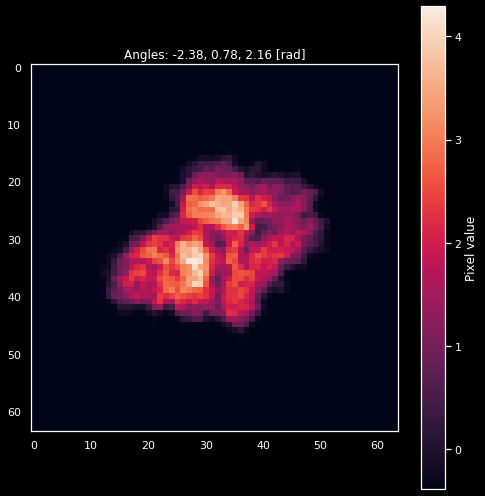

In [20]:
plot_projection(np.squeeze(projections_test[0]).astype(np.float32), angles=angles_true_test[0])

In [21]:
type(projections_train[0][0][0][0])

numpy.float16

In [22]:
from cryoem.plots import plot_detector_pixels, plot_rotvec

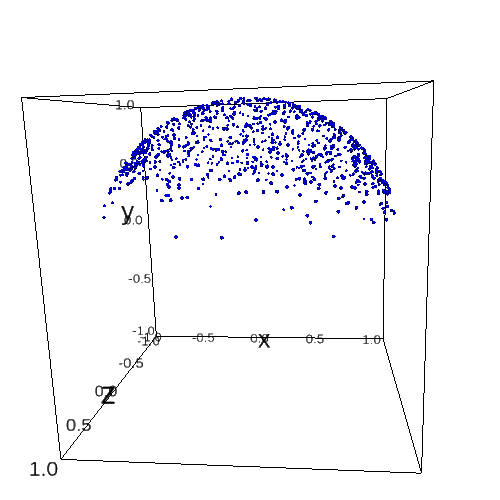

In [47]:
plot_detector_pixels(angles_true_test)

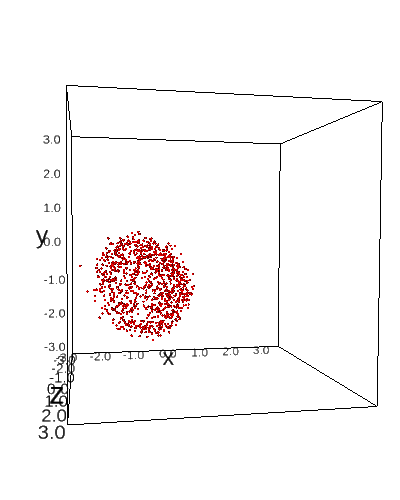

In [50]:
plot_rotvec(angles_true_test)

In [51]:
ipv.screenshot()

Output()

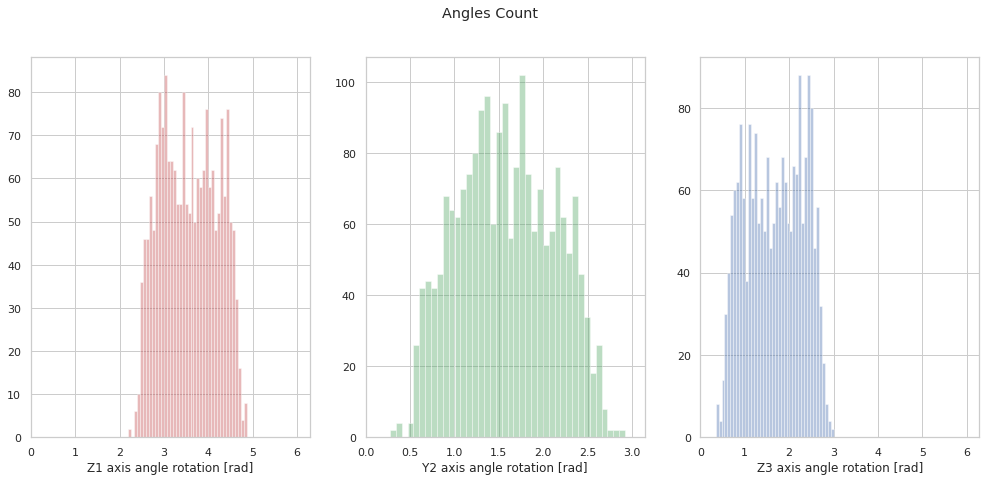

In [24]:
plot_angles_count(np.array(angles_true_test))

---

In [25]:
from tensorflow_graphics.util import safe_ops, asserts, shape

def d_geo(m1, m2):
    m = tf.matmul(m1, tf.linalg.inv(m2))
    m = tf.reshape(m, shape=[-1, 3, 3])
    acos_in = (tf.linalg.trace(m)-1)/2
    
    # Ensure dot product is in range [-1. 1].
    eps_dot_prod = 1.8 * asserts.select_eps_for_addition(acos_in.dtype)
    acos_in = safe_ops.safe_shrink(acos_in, -1, 1, open_bounds=False, eps=eps_dot_prod)
    
    return tf.math.acos(acos_in)

def gGS(a):
    a1, a2, a3 = tf.unstack(a, axis=-1)
    return tf.stack((a1, a2), axis=-1)


def fGS(a):
    a1, a2 = tf.unstack(a, axis=-1)
    b1 = a1/tf.transpose(tf.broadcast_to(tf.linalg.norm(a1, axis=1), shape=[3, len(a)]))
    b2 = a2 - tf.transpose(tf.broadcast_to(tf.reduce_sum(b1 * a2, 1), shape=[3,len(a)])) * b1
    b2 = b2/tf.transpose(tf.broadcast_to(tf.linalg.norm(b2, axis=1), shape=[3, len(a)]))  #tf.linalg.norm(b2, axis=0)
    b3 = tf.linalg.cross(b1, b2)
    
    return tf.stack((b1,b2,b3), axis=-1)
    

## (2) Distance Learning

In [26]:
PROJECTIONS_NUM = NUM_TRAIN_PROTEINS * PROJECTIONS_NUM_SINGLE
PROJECTIONS_NUM

3000

In [27]:
DE_LOGS_DIR = f"{RESULTS_DIR}/distance_estimation_full"
DE_DESCRIPTION = "full_pipeline_unseen_proteins"

In [28]:
train_idx, val_idx, test_idx, train_pairs_num, val_pairs_num = train_val_test_split(PROJECTIONS_NUM, test_size=0.01, val_size=0.35, train_percent=0.01, val_percent=0.01, indices_file="")

TRAIN: 0.99 x 0.65 = 0.64 =>  1930 imgs => max pairs:    3724900   |   37249
TEST :               0.01 =>    30 imgs => max pairs:        900   |   all
VAL  : 0.99 x 0.35 = 0.35 =>  1040 imgs => max pairs:    1081600   |   10816
Indices stored in 


In [29]:

#import tensorflow_probability as tfp
import os
import h5py
from time import time, strftime
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import pathlib

from cryoem.rotation_matrices import RotationMatrix
from cryoem.conversions import euler2quaternion, d_q
from cryoem.knn import get_knn_projections

import random
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.python.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AvgPool2D, Lambda, ZeroPadding2D, Dropout, Concatenate, Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model, multi_gpu_model
#from tensorflow.python.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.losses import KLD, MAE, MSE
from tensorflow.keras.utils import Sequence
import pandas as pd
import seaborn as sns
import io
from scipy.spatial.transform import Rotation as R


num_dec = 1
num_bins = 32

# # for weights
# dQ_values = np.load("data/5j0n/dQ_values_100K.npy")
# distribution = np.histogram(dQ_values, bins=32, range=(0.0, np.pi), density=True)
# probabilities = distribution[0]
# weights = 1/probabilities
# weights_norm = weights/sum(weights)

class DataGenerator(Sequence):
    
    def __init__(self, X, y, list_ids, limit_num_pairs=None, limit_style="random", batch_size=256, shuffle=True):
        start_time = time()
        if batch_size > limit_num_pairs:
            raise Exception("Please specify limit_num_pairs that is much higher than batch_size")
        self.X = X  
        self.y = y  
        self.y_matrix = R.from_euler('zyz', self.y).as_matrix()
        self.limit_num_pairs = limit_num_pairs
        self.list_ids = list_ids
        self.batch_size = batch_size  
        # all the possible combinations of 2 image id pairs
        self.pair_ids = np.array(list(zip(*list(map(lambda x: x.flatten(), np.meshgrid(list_ids, list_ids))))))  # e.g. train_idx
        
        # Don't use all possible combination of pairs, limit them here
        if self.limit_num_pairs:
            limited_pair_indices = np.random.choice(np.arange(len(self.pair_ids)), size=self.limit_num_pairs)
            self.pair_ids = self.pair_ids[limited_pair_indices]
        
        if limit_style=="uniform":
            self.pair_ids = self._generate_uniform()
      
        self.shuffle = shuffle 
        self._on_epoch_start()
        print(f"Data created in {time()-start_time} sec")
        
        
    def _generate_uniform(self):
        if os.path.exists(f"data/5j0n/{len(self.list_ids)}_{self.limit_num_pairs}_{self.batch_size}.npy"):
            return np.load(f"data/5j0n/{len(self.list_ids)}_{self.limit_num_pairs}_{self.batch_size}.npy")
        else:
            bins = {}
            for i in np.arange(0.0, 3.14, step=0.1): # so we have 32 bins
                bins[np.around(i, num_dec)] = []


            for idx1, idx2 in self.pair_ids:
                label = d_q(euler2quaternion(self.y[idx1]), euler2quaternion(self.y[idx2]))
                bins[np.around(label, num_dec)].append([idx1, idx2])

            min_bin_size = len(bins[min(bins.keys(), key=lambda x: len(bins[x]))])
            print("min=", min_bin_size)
            if min_bin_size == 0:
                raise Exception("It haven't yet managed to fill all the bins, please increase limit_num_pairs")


            # cut the top of histogram to make it uniform
            for i in np.arange(0.0, 3.14, step=0.1): # so we have 32 bins
                b = np.around(i, num_dec)
                bins[b] = np.take(bins[b], np.arange(min_bin_size), axis=0)  

            l = np.array(list(itertools.chain(*list(bins.values()))))
            np.save(f"data/5j0n/{len(self.list_ids)}_{self.limit_num_pairs}_{self.batch_size}.npy", l)
            print("total number of data = ", 31*min_bin_size)
            return l
    
    def __len__(self):
        # Denotes the number of batches per epoch
        if len(self.pair_ids)%self.batch_size == 0:
            return len(self.pair_ids) // self.batch_size
        else:
            return len(self.pair_ids) // self.batch_size + 1
        
    def __getitem__(self, index):
        # Generate one batch of data
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        
        # Find list of ids
        list_ids_batch = np.take(self.pair_ids, indices, axis=0)

        # Generate data
        idx1, idx2 = list_ids_batch[:,0], list_ids_batch[:,1]
        pairs = np.stack((self.X[idx1], self.X[idx2]), axis=1) 

        #labels = d_q(euler2quaternion(self.y[idx1]), euler2quaternion(self.y[idx2])) 
        labels = d_geo(self.y_matrix[idx1], self.y_matrix[idx2])

        return (pairs[:, 0], pairs[:, 1]), labels 
        
    def _on_epoch_start(self):
        # Updates indices after each epoch
        self.indices = np.arange(len(self.pair_ids))
        if self.shuffle:
            np.random.shuffle(self.indices)

# _idx1 = list(np.random.choice(val_idx, size=1000))
# _idx2 = list(np.random.choice(val_idx, size=1000))

# q1_true = euler2quaternion([angles_true[i] for i in _idx1])
# q2_true = euler2quaternion([angles_true[i] for i in _idx2])

# p1 = [X[i] for i in _idx1]
# p2 = [X[i] for i in _idx2]

model = None

def cosine_distance(vests):
    x, y = vests
    xy_sum_square = K.sum(x * y, axis=1, keepdims=True) 
    xx_sum_square = K.sum(x * x, axis=1, keepdims=True)
    xx_sum_square = K.maximum(xx_sum_square,  1e-08) 
    yy_sum_square = K.sum(y * y, axis=1, keepdims=True)
    yy_sum_square = K.maximum(yy_sum_square, 1e-08) 
    
    cos_theta = tf.divide(xy_sum_square, K.sqrt(xx_sum_square)*K.sqrt(yy_sum_square))
    eps = K.epsilon()
    return 2*tf.acos(tf.clip_by_value(cos_theta, 0.0+eps, 1.0-eps)) 

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def mae(y_true, y_pred):
    return MAE(y_true, y_pred) 

def mse(y_true, y_pred):
    return MSE(y_true, y_pred) 


def create_siamese_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_x = Input(shape=input_shape)
    #print(input_shape)

    # add Convolution, MaxPool, Conv2D, remove Dropout and Dense
    
    x = Conv2D(filters=32, kernel_size=[7, 7], activation='relu', padding='same', kernel_initializer='glorot_uniform')(input_x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(64, [5, 5], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(128, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)

    x = Conv2D(256, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    
    x = Conv2D(256, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    
    x = Conv2D(512, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    
    x = Conv2D(512, [3, 3], activation='relu', padding='same', kernel_initializer='glorot_uniform')(x)
    x = MaxPooling2D([2, 2], padding='same')(x)
    
    x = AvgPool2D(pool_size=[8, 8], padding='same')(x)

    x = tf.squeeze(x, axis=[1,2])
    
    return Model(input_x, x)


def train_distance_estimation(X, y, train_idx, val_idx, epochs, batch_size, learning_rate, limit_style, path_logs_training, training_description="", training_steps=None, validation_steps=None, plot=True, gpus=None, file_name=None):
    
    
    def d_p(p1, p2):
        global model
        p1 = tf.cast(p1, dtype=tf.float32)
        p2 = tf.cast(p2, dtype=tf.float32)
        return model.predict([p1, p2], batch_size=256)

    def plot_to_image(figure):
        """Converts the matplotlib plot specified by 'figure' to a PNG image and
        returns it. The supplied figure is closed and inaccessible after this call."""
        # Save the plot to a PNG in memory.
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        # Closing the figure prevents it from being displayed directly inside
        # the notebook.
        plt.close(figure)
        buf.seek(0)
        # Convert PNG buffer to TF image
        image = tf.image.decode_png(buf.getvalue(), channels=4)
        # Add the batch dimension
        image = tf.expand_dims(image, 0)
        return image

    def generate_dPdQ_plot(file_writer_plot, val_idx, y, X):
        """Source: https://www.tensorflow.org/tensorboard/image_summaries#logging_arbitrary_image_data"""

        _idx1 = list(np.random.choice(val_idx, size=1000))
        _idx2 = list(np.random.choice(val_idx, size=1000))

        q1_true = euler2quaternion([y[i] for i in _idx1])
        q2_true = euler2quaternion([y[i] for i in _idx2])

        p1 = [X[i] for i in _idx1]
        p2 = [X[i] for i in _idx2]

        def _inner_plot(epoch, logs):
            """Generate dP/dQ plot for tensorboard"""
            dP_values = d_p(p1, p2).T[0]
            dQ_values = d_q(q1_true, q2_true).numpy()

            # Creating the dataframe for SNS plot
            data = {"d_Q" : dQ_values, "d_P" : dP_values }
            df1 = pd.DataFrame(data=data)

            fig, ax = plt.subplots(figsize=(6,6));
            sns.scatterplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", ax=ax);  # "reg", "kde"
            x = np.arange(0, np.pi);
            sns.regplot(x=x, y=x, color="k", ax=ax)
            #g = sns.jointplot(x="d_Q", y="d_P", data=df1, color="b", alpha=0.3, label="projection pair", kind="kde");  # "reg", "kde"
            #plt.show()
            
            # Log the confusion matrix as an image summary.
            with file_writer_plot.as_default():
                tf.summary.image("dP/dQ plot", plot_to_image(fig), step=epoch)
        
        return _inner_plot

    mirrored_strategy = tf.distribute.MirroredStrategy()
    
    with mirrored_strategy.scope():
        # Prepare data generators
        training_generator = DataGenerator(X, y, train_idx, limit_num_pairs=training_steps, limit_style=limit_style, shuffle=True)
        validation_generator = DataGenerator(X, y, val_idx, limit_num_pairs=validation_steps, limit_style=limit_style, shuffle=True)
        
        input_shape = tuple(list(X.shape[1:])) #training_pairs[:, 0].shape[1:]
        print(f"Input images shape {input_shape}")

        # network definition
        input_a = Input(shape=input_shape)
        input_b = Input(shape=input_shape)
        cnn_network = create_siamese_network(input_shape)
        
        # because we re-use the same instance `cnn_network`,
        # the weights of the network will be shared across the two branches
        processed_a = cnn_network(input_a)
        processed_b = cnn_network(input_b)

        
        distance = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([processed_a, processed_b])

        global model
        model = Model([input_a, input_b], distance)  # was m

        # train
        #model = multi_gpu_model(m, gpus=gpus)
        model.summary()
        #plot_model(model, to_file="figures/model_plot.png", expand_nested=True, show_shapes=True, show_layer_names=True)

        # training only top layers
        optimizer1 = RMSprop(learning_rate=learning_rate)
        model.compile(loss=mae, optimizer=optimizer1, metrics=[mse], sample_weight_mode=None)

        # Setup callbacks
        # Callback that saves the model
        training_description = training_description or strftime('%Y%m%d_%H%M%S')
        CHECKPOINT_PATH = os.path.join(f"{path_logs_training}/training", f"{training_description}.h5")
        pathlib.Path(f"{path_logs_training}/training").mkdir(parents=True, exist_ok=True)
        backup_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_PATH, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        print(f"Model will be saved to: {CHECKPOINT_PATH}")
        # Callback that will show tensorboard data
        LOGS_PATH = os.path.join(f"{path_logs_training}/logs", f"{training_description}")
        pathlib.Path(LOGS_PATH).mkdir(parents=True, exist_ok=True)
        logs_callback = TensorBoard(LOGS_PATH, histogram_freq=1) #, profile_batch=300)#100000000)
        # Callback for the dP/dQ plot
        file_writer_plot = tf.summary.create_file_writer(os.path.join(LOGS_PATH, "image"))
        plot_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=generate_dPdQ_plot(file_writer_plot, val_idx, y, X))
        # Callback that will decrease LR if it gets plateau in val_loss
        #reduce_on_plateau_callback = ReduceLROnPlateau(monitor="loss", mode="min", factor=0.1, patience=20, min_lr=1e-4, verbose=1)



        history1 = model.fit(training_generator, 
                            epochs=epochs,
                            validation_data=validation_generator, 
                            callbacks=[plot_callback, logs_callback, backup_callback])
        
        # Get training and test loss histories
        training_loss = history1.history['loss']
        val_loss = history1.history['val_loss']
        mses = history1.history['mse']
        val_mses = history1.history['val_mse']
        pathlib.Path(f"{path_logs_training}/losses").mkdir(parents=True, exist_ok=True)
        np.savez(f"{path_logs_training}/losses/losses.npz", training_loss, val_loss, mses, val_mses)

        if plot:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

            # Create count of the number of epochs
            epoch_count = range(1, len(training_loss) + 1)

            # Visualize loss history
            ax1.plot(epoch_count, training_loss, 'r--', label='MAE Training Loss')
            ax1.plot(epoch_count, val_loss, 'b-', label='MAE Validation Loss')
            ax1.legend()
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')

            ax2.plot(epoch_count, mses, 'r-', label='MSE Training')
            ax2.plot(epoch_count, val_mses, 'b-', label='MSE Validation')
            ax2.legend()
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Loss')
            
            if file_name:
                plt.savefig(file_name)

            plt.show();

        return model, history1

def plot_results(projections, y_pred, y, strtype):
    if projections.shape[-1] == 1:
        projections = projections.reshape(list(projections.shape[:-2]) +[-1])

    def _inner(i):
        
        plt.imfig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(projections[i, 0])
        ax2.imshow(projections[i, 1])

        print(f"--- {strtype} Set ---")
        print(f"predicted: {y_pred[i][0]}")
        print(f"true:      {y[i].numpy()}")
        print(f"mse:       {mse(y_pred[i], y[i].numpy())}")
        print(f"mae:       {mae(y_pred[i], y[i].numpy())}")
        
    return _inner

Data created in 2.148017168045044 sec
Data created in 0.5974125862121582 sec
Input images shape (64, 64, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
___________________________________________________________________________________

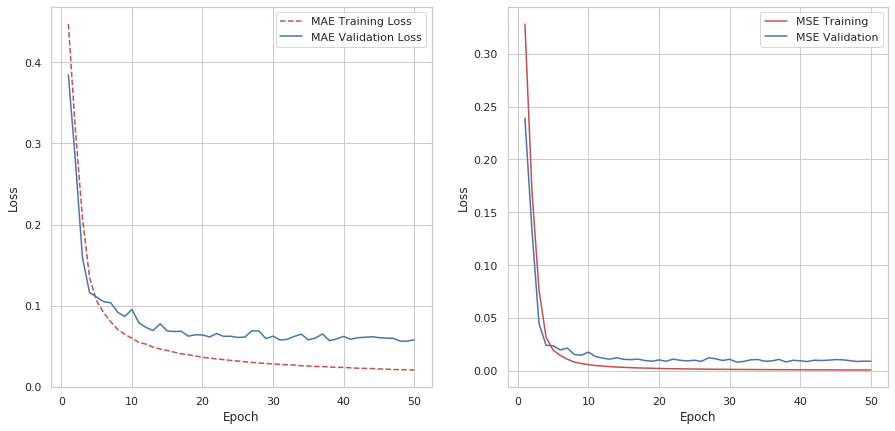

In [30]:
model, history = train_distance_estimation(X=projections_train, y=angles_true_train, 
                                           train_idx=train_idx, 
                                           val_idx=val_idx,
                                           epochs=50,
                                           batch_size=256,  #512 latest 
                                           learning_rate=1e-3, 
                                           limit_style="random", 
                                           path_logs_training=DE_LOGS_DIR, 
                                           training_description=DE_DESCRIPTION,
                                           training_steps=train_pairs_num,
                                           validation_steps=val_pairs_num, 
                                           plot=True,
                                           gpus=None)

In [31]:
# read stored model
model_filename = f"{DE_LOGS_DIR}/training/{DE_DESCRIPTION}.h5"

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [32]:
# learned distance function
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=128)

<Figure size 432x288 with 0 Axes>

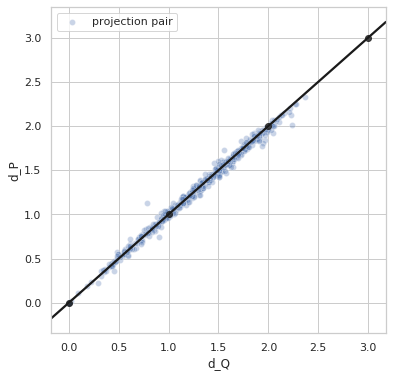

<Figure size 432x288 with 0 Axes>

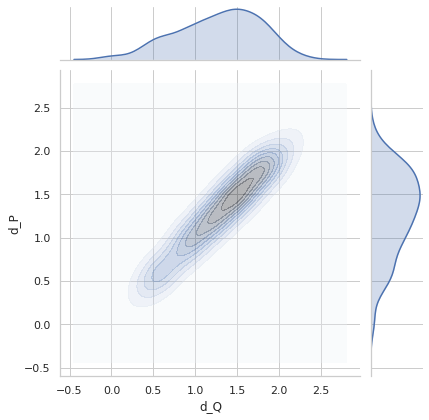

Variance = 0.043050714239406464
Min. angle recovery loss possible = 0.0018497441449673252


In [33]:
# dP/dQ ratio plot
batch_size = 512
idx1 = list(np.random.choice(range(100), size=batch_size))
idx2 = list(np.random.choice(range(100), size=batch_size))

q1_true = euler2quaternion([angles_true_train[i] for i in idx1])
q2_true = euler2quaternion([angles_true_train[i] for i in idx2])

p1 = [projections_train[i] for i in idx1]
p2 = [projections_train[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

plot_dP_dQ(dP_values, dQ_values, f"{DE_LOGS_DIR}/dPdQ.png");

In [34]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

## (4) Angle Recovery

In [35]:
from cryoem.angle_recovery import train_angle_recovery

In [36]:
AR_LOGS_DIR = f"{RESULTS_DIR}/angle_recovery_full"
AR_TRAINING_DESCRIPTION = "full_pipeline_unseen_proteins_small2" #_ALL"

In [37]:
projections_test.shape

(2000, 64, 64, 1)

In [38]:
M = R.from_euler('zyz', angles_true_test[0].astype(np.float64)).as_matrix()
d_geo(M, M)

<tf.Tensor: id=238549, shape=(1,), dtype=float64, numpy=array([3.94247668e-08])>

In [39]:
M = R.from_euler('zyz', angles_true_test[:2].astype(np.float64)).as_matrix()
d_geo(M, M)

<tf.Tensor: id=238567, shape=(2,), dtype=float64, numpy=array([3.94247668e-08, 3.94247668e-08])>

In [40]:
M1 = R.from_euler('zyz', angles_true_test[:4].astype(np.float64)).as_matrix()
M2 = R.from_euler('zyz', angles_true_test[:4][::-1].astype(np.float64)).as_matrix()
d_geo(M1, M2)

<tf.Tensor: id=238585, shape=(4,), dtype=float64, numpy=array([1.62875757, 1.63915282, 1.63915282, 1.62875757])>

In [41]:
# QUATERNION VARIABLE
import time
import numpy as np
from IPython import display as IPyDisplay
from tensorflow.keras.optimizers import Adam
import seaborn as sns; sns.set(style="white", color_codes=True)
#from tensorflow_graphics.geometry.transformation import quaternion
#from cryoem.conversions import euler2quaternion, d_q, quaternion2euler
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from pathlib import Path

# TODO: add constraint on quaternion Variables


# def angles_transpose(angles):
#     angles = angles.copy()
#     cols = [2, 1, 0]
#     idx = np.empty_like(cols)
#     idx[cols] = np.arange(len(cols))
#     angles[:] = -angles[:, idx]
#     return angles

# def quaternion_constraint(low_ang, high_ang):
    
#     def _inner(q):
#         e = quaternion2euler(q)

#         a0, a1, a2 = tf.unstack(e, axis=-1)
#         a0 = tf.clip_by_value(a0, low_ang[0], high_ang[0])
#         a1 = tf.clip_by_value(a1, low_ang[1], high_ang[1])
#         a2 = tf.clip_by_value(a2, low_ang[2], high_ang[2])

#         e_new = tf.stack((a0, a1, a2), axis=-1)
#         q_new = euler2quaternion(e_new)
#         return q_new

#     return _inner
    



def train_angle_recovery(steps, 
                         batch_size, 
                         in_data, 
                         distance_fn, 
                         file_name,
                         limit_distance=np.pi,
                         low_ang_const=[0.0, 0.0, 0.0],
                         high_ang_const=[2.0, 0.4, 2.0],
                         predicted=None,
                         angles_true=None,
                         learning_rate=0.01,
                         constraint=False): 

    time_start = time.time()
    collect_data = []
    optimizer = Adam(learning_rate=learning_rate)

    #low_ang = [0.0*np.pi, 0.0*np.pi, 0.0*np.pi]
    low_ang = list(map(lambda x: x*np.pi, low_ang_const))
    #high_ang = [2.0*np.pi, 0.4*np.pi, 2.0*np.pi] 
    high_ang = list(map(lambda x: x*np.pi, high_ang_const))           
    euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
                          high=[high_ang[0], high_ang[1], high_ang[2]],
                          size=(len(in_data), 3))
    
    M_euler = R.from_euler('zyz', euler).as_matrix()
    
    if predicted:
        # continue where left off
        if constraint:
            predicted = [tf.Variable(p, constraint=quaternion_constraint(low_ang, high_ang)) for p in predicted]
        else:
            predicted = [tf.Variable(p) for p in predicted]
    else:
        # optimize from scratch
        if constraint:
            predicted = [tf.Variable(p, constraint=quaternion_constraint(low_ang, high_ang)) for p in gGS(M_euler)]
        else:
            predicted = [tf.Variable(p) for p in gGS(M_euler)]

    if in_data.shape[1] == 3:
        in_data = gGS(in_data)

    
    losses = np.empty(steps)
    report = f"Shape of projections: {in_data.shape}"
    found_minimizer = False

    print(time.time()-time_start)
    

    for step, idx1, idx2 in sample_iter(steps, range(len(in_data)), batch_size, style="random"):
        #print(f"Step - {step}")
        q1 = [predicted[i] for i in idx1]
        q2 = [predicted[i] for i in idx2]
        #q1 = np.array(q1)
        #q2 = np.array(q2)
        #print(q1)

        # Compute distances
        in1 = [in_data[i] for i in idx1]
        in2 = [in_data[i] for i in idx2]
        #in1 = np.array(in1)
        #in2 = np.array(in2)

        distance_target = distance_fn(in1, in2)

        # Optimize by gradient descent.
        losses[step-1], gradients = gradient(q1, q2, distance_target)
        optimizer.apply_gradients(zip(gradients, q1 + q2))

        # Visualize progress periodically
        if step % 10 == 0:

            plt.close();
            sns.set(style="white", color_codes=True)
            sns.set(style="whitegrid")

            if angles_true is not None:
                fig, axs = plt.subplots(1, 3, figsize=(24,7))

                # Optimization loss subplot
                axs[0].plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
                axs[0].set_xlabel('time [s]')
                axs[0].set_ylabel('loss');
                axs[0].set_title(f"[{step}/{steps}] Angle alignment optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")

                # NT - Distance count subplot (full)
                d2 = d_q(R.from_euler('zyz', angles_true).as_quat(), predicted)
                axs[1].set_xlim(0, np.pi)
                axs[1].set_title(f"[{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
                s = sns.distplot(d2, kde=False, bins=100, ax=axs[1], axlabel="Distance [rad]", color="r")
                max_count = int(max([h.get_height() for h in s.patches]))
                axs[1].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

                # T - Distance count subplot (full)
                angles_true_T = angles_transpose(angles_true)
                d2 = d_q(R.from_euler('zyz', angles_true_T).as_quat(), predicted)
                axs[2].set_xlim(0, np.pi)
                axs[2].set_title(f"[{step}/{steps}] TRANSPOSED Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} rad ({np.degrees(np.mean(d2)):.2e}) STD={np.std(d2):.2e}")
                s = sns.distplot(d2, kde=False, bins=100, ax=axs[2], axlabel="Distance [rad]", color="r")
                max_count = int(max([h.get_height() for h in s.patches]))
                axs[2].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
            else:
                fig, axs = plt.subplots(figsize=(10,7))

                # Optimization loss subplot
                axs.plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
                axs.set_xlabel('time [s]')
                axs.set_ylabel('loss');
                axs.set_title(f"[{step}/{steps}] Angle recovery optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")


            IPyDisplay.clear_output(wait=True)
            IPyDisplay.display(plt.gcf())
            plt.close();
            time.sleep(0.1)

            Path(file_name).mkdir(parents=True, exist_ok=True)
            np.savez(file_name, predicted, losses, np.array(collect_data))

            if found_minimizer:
                time_elapsed = time.time() - time_start
                report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}\n'
                break;

        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time.time() - time_start
            report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}\n'

        if step >= 1001 and np.mean(losses[step-1001:step-1]) < 1e-8:
            found_minimizer = True

        if step >= 2001 and np.abs(np.mean(losses[step-1000:step-1])-np.mean(losses[step-2000:step-1000])) < 1e-7:
            found_minimizer = True

    print(report)
    return fGS(predicted), losses, np.array(collect_data)

def sample_iter(steps, projection_idx, num_pairs, style="random", k=None):

    for step in range(1, steps+1):
        if not k and style != "random":
            raise ValueError("Please specify k for kNN for sample_pairs method")

        if style=="random":
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))
            idx2 = list(np.random.choice(projection_idx, size=num_pairs))

        elif style=="knn":
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))
            indices_p, distances_p, A_p = get_knn_projections(k=k)
            idx2 = [indices_p[i][np.random.randint(1, k)] for i in idx1]

        elif style=="knn_and_random":
            # select random sample for the first element of pair
            idx1 = list(np.random.choice(projection_idx, size=num_pairs))

            # half from kNN
            indices_p, distances_p, A_p = get_knn_projections(k=k)
            idx2_knn = [indices_p[i][np.random.randint(1, k)] for i in idx1[:num_pairs//2]]
            idx2_random = list(np.random.randint(0, num_projections, num_pairs//2))
            # half random
            idx2 = idx2_knn + idx2_random

        yield step, idx1, idx2

def loss(p1, p2, distance_target):
   
    distance_predicted = d_geo(fGS(p1), fGS(p2))
    
    #dist_target_probs = get_probability(distance_target)
    #dist_predicted_probs = get_probability(distance_predicted)
    
    
    return tf.reduce_mean(tf.pow((distance_predicted - distance_target), 2)) #+ tf.keras.losses.KLD(dist_target_probs, dist_predicted_probs)

def gradient(p1, p2, distance_target):
    with tf.GradientTape() as tape:
        loss_value = loss(p1, p2, distance_target)
    #print(loss_value)
    gradient = tape.gradient(loss_value, p1 + p2)
    #print(gradient)
    return loss_value, gradient



In [42]:
# def get_probability(arr):
#     bins = np.arange(np.floor(arr.min()), np.ceil(arr.max()))
#     values, base = np.histogram(arr, bins=bins, density=1)
#     arr_probs = []
#     for i in arr:
#         for j in range(len(bins)-1):
#             if i >= bins[j] and i < bins[j+1]:
#                 arr_probs.append(values[j])
#                 break
#         else:
#             arr_probs.append(values[j])
#     return np.array(arr_probs)
    

In [43]:
# M_euler = R.from_euler('zyz', angles_true_test).as_matrix()
# predicted = [tf.Variable(p) for p in gGS(M_euler)]

# idx1 = list(np.random.choice(len(predicted), size=100))
# idx2 = list(np.random.choice(len(predicted), size=100))

# p1 = [predicted[i] for i in idx1]
# p2 = [predicted[i] for i in idx2]

# in1 = [projections_test[i] for i in idx1]
# in2 = [projections_test[i] for i in idx2]
# distance_target = d_p(in1, in2)

# loss(p1, p2, distance_target)

In [44]:
# x = np.array([1,1,1,2,2,3,3,3,3,3,3,4,4,4, 5])
# print(x.shape)
# y = get_probability(x)
# print(y.shape)

In [73]:
q_predicted, losses, q_all = train_angle_recovery(steps=30000, 
                                                 batch_size=128, 
                                                 in_data=projections_train, 
                                                 distance_fn=d_p, 
                                                 learning_rate=5, 
                                                 limit_distance=np.pi,
                                                 low_ang_const=ANGLE_SHIFT,
                                                 high_ang_const=[sum(x) for x in zip(ANGLE_SHIFT, ANGLE_COVERAGE)],
                                                 file_name=f"{AR_LOGS_DIR}/{AR_TRAINING_DESCRIPTION}",
                                                 constraint=False)

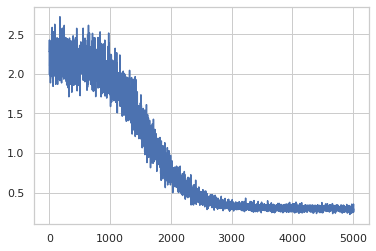

In [46]:
data = np.load(f"{AR_LOGS_DIR}/{AR_TRAINING_DESCRIPTION}.npz", allow_pickle=True)
q_predicted, losses, collect_data = data['arr_0'], data['arr_1'], data['arr_2']
plt.plot(data["arr_1"][:8000])

In [47]:
q_predicted

array([<tf.Variable 'Variable:0' shape=(3, 2) dtype=float64, numpy=
array([[ 13.12858184,  73.79475103],
       [148.09192584,  65.91622195],
       [ 14.41444263,  43.27444847]])>,
       <tf.Variable 'Variable:0' shape=(3, 2) dtype=float64, numpy=
array([[ 39.37469732,  76.02919418],
       [148.98561777, 120.37778283],
       [ -4.26594877,  24.97119863]])>,
       <tf.Variable 'Variable:0' shape=(3, 2) dtype=float64, numpy=
array([[ 13.05030537,  84.38639588],
       [ 88.56290931, -18.79479857],
       [ 42.11130577, -21.97554171]])>,
       ...,
       <tf.Variable 'Variable:0' shape=(3, 2) dtype=float64, numpy=
array([[ 55.70874367,  65.05274393],
       [130.33461315, -46.3237497 ],
       [ 20.51668717,  36.41899365]])>,
       <tf.Variable 'Variable:0' shape=(3, 2) dtype=float64, numpy=
array([[ 25.44825623,   6.98319552],
       [  8.47348933, -34.97229634],
       [111.74555952, -87.62190312]])>,
       <tf.Variable 'Variable:0' shape=(3, 2) dtype=float64, numpy=
array([[ 4

In [48]:
rot_matrix_predicted = np.empty((len(q_predicted), 3, 3))
for i, q in enumerate(q_predicted):
    #print(np.array([q.numpy()]))
    rot_matrix_predicted[i] = fGS(np.array([q.numpy()]))

In [49]:
angles_predicted = R.from_matrix(rot_matrix_predicted).as_euler('zyz')

In [ ]:
# angles_predicted = quaternion2euler(q_predicted)

---

In [ ]:
q_true = euler2quaternion(angles_true_test)

In [ ]:
ipv.figure(width=500, height=500)
ipv.scatter(q_true[:,0], q_true[:,1], q_true[:,2], marker="sphere", color="blue", size=1)
ipv.xlim(-1,1);ipv.ylim(-1,1);ipv.zlim(-1,1)
ipv.show()


In [ ]:
for i, q in enumerate(q_predicted):
    if q[3] < 0:
        q_predicted[i] = -q_predicted[i]

In [ ]:
q0 = q_true[:,3]
q1 = q_true[:,0]
q2 = q_true[:,1]
q3 = q_true[:,2]

r = np.sqrt(q0**2+q1**2)
t = np.sqrt(1+ np.sqrt((r**2+r*q0)/2))

x = 2*np.sign(q1)/t*np.sqrt(r**2 - r*q0)
y = np.sqrt(2)/t*q2
z = np.sqrt(2)/t*q3

ipv.figure(width=500, height=500)
ipv.scatter(x, y, z, marker="sphere", color="blue", size=1)
ipv.scatter(q_true[:,0], q_true[:,1], q_true[:,2], marker="sphere", color="red", size=1)
#ipv.xlim(-1,1);ipv.ylim(-1,1);ipv.zlim(-1,1)
ipv.show()


In [ ]:
q0 = q_predicted[:,3]
q1 = q_predicted[:,0]
q2 = q_predicted[:,1]
q3 = q_predicted[:,2]

r = np.sqrt(q0**2+q1**2)
t = np.sqrt(1+ np.sqrt((r**2+r*q0)/2))

x = 2*np.sign(q1)/t*np.sqrt(r**2 - r*q0)
y = np.sqrt(2)/t*q2
z = np.sqrt(2)/t*q3

ipv.figure(width=500, height=500)
ipv.scatter(x, y, z, marker="sphere", color="blue", size=1)
ipv.scatter(q_true[:,0], q_true[:,1], q_true[:,2], marker="sphere", color="red", size=1)
#ipv.xlim(-1,1);ipv.ylim(-1,1);ipv.zlim(-1,1)
ipv.show()


In [ ]:
ipv.figure(width=500, height=500)
ipv.scatter(q_predicted[:,0], q_predicted[:,1], q_predicted[:,2], marker="sphere", color="blue", size=1)
ipv.scatter(q_predicted[:,0], q_predicted[:,1], q_predicted[:,2], marker="sphere", color="red", size=1)
ipv.xlim(-1,1);ipv.ylim(-1,1);ipv.zlim(-1,1)
ipv.show()


In [ ]:
xt = np.array(angles_true_test)[:,0]
yt = np.array(angles_true_test)[:,1]
zt = np.array(angles_true_test)[:,2]

xp = np.array(angles_predicted)[:,0]
yp = np.array(angles_predicted)[:,1]
zp = np.array(angles_predicted)[:,2]

r = 1.
connections = True
selected = range(1000)
interval = 1

N = len(selected)
steps = len(xt)
x = np.zeros((steps, 2*N))
y = np.zeros((steps, 2*N))
z = np.zeros((steps, 2*N))

for i in range(0, steps):
    x[i] = np.concatenate([r*np.cos(xt)*np.cos(yt), r*np.cos(xp)*np.cos(yp)])
    y[i] = np.concatenate([r*np.sin(xt)*np.cos(yt), r*np.sin(xp)*np.cos(yp)])
    z[i] = np.concatenate([r*np.sin(yt), r*np.sin(yp)])

ipv.figure(width=500, height=500)
lines = [[i, i+N] for i in range(N)]

if connections:
    s = ipv.scatter(r*np.cos(xt)*np.cos(yt), r*np.sin(xt)*np.cos(yt), r*np.sin(yt), marker="sphere", color="red", size=1)
    ipv.scatter(r*np.cos(xp)*np.cos(yp), r*np.sin(xp)*np.cos(yp), r*np.sin(yp), marker="sphere", color="blue", size=1)
    p = ipv.plot_trisurf(x, y, z, lines=lines);
    #ipv.animation_control([s, p], interval=interval)


#ipv.scatter(r*np.cos(xt)*np.cos(yt), r*np.sin(xt)*np.cos(yt), r*np.sin(yt), marker="sphere", color="red", size=1)
#ipv.scatter(r*np.cos(xp)*np.cos(yp), r*np.sin(xp)*np.cos(yp), r*np.sin(yp), marker="sphere", color="blue", size=1)
ipv.xlim(-1,1);ipv.ylim(-1,1);ipv.zlim(-1,1)
ipv.show()


In [ ]:
x = np.array(angles_predicted)[:,0]
y = np.array(angles_predicted)[:,1]
z = np.array(angles_predicted)[:,2]
r = 1.

ipv.figure(width=500, height=500)
ipv.scatter(r*np.cos(x)*np.cos(y), r*np.sin(x)*np.cos(y), r*np.sin(y), marker="sphere", color="blue", size=1)
ipv.xlim(-1,1);ipv.ylim(-1,1);ipv.zlim(-1,1)
ipv.show()


In [ ]:
plt.hist(q_predicted[:,3])

## (5) Angle Alignment

In [50]:
from cryoem.angle_alignment import training_angle_alignment

In [51]:
# angles_predicted = angles_predicted.numpy().astype(np.float16)

m= [1.0, 1.0, 1.0, -1.0] 
trajectory_first= [4.22851293 1.4471432  3.35010256 4.91616526 5.93385266 3.30290737] 
loss_first= 1.758349904458179 
trajectory_last= [ 49.86729248   3.63541642   1.0450916    8.60784724 -18.81310535
   5.62460922] 
loss_last= 1.1020525436410649


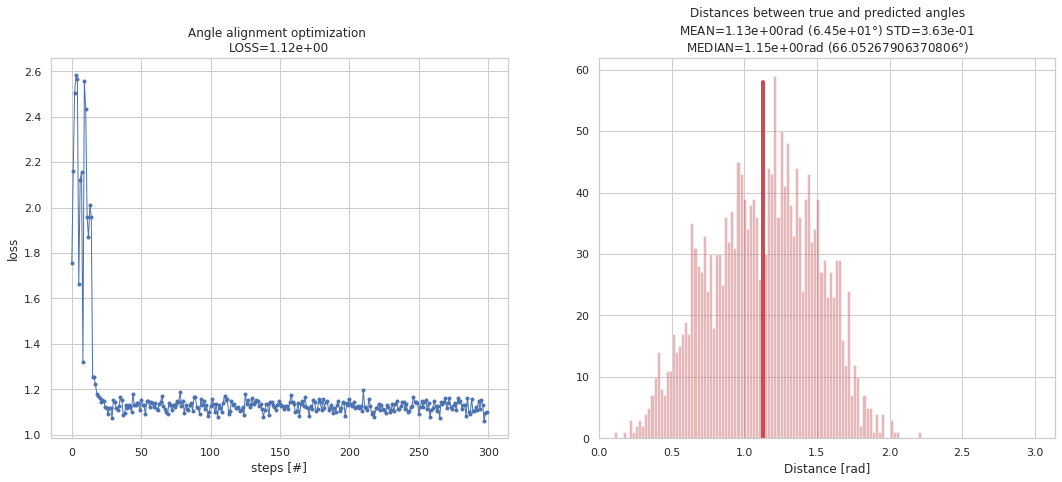

In [52]:
%matplotlib inline
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=3, 
                                                                    steps=300, 
                                                                    batch_size=256, 
                                                                    optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                                    angles_true=angles_true_test, 
                                                                    angles_predicted=angles_predicted,
                                                                    threshold=None,
                                                                    dtype=tf.float64)

In [53]:
from cryoem.plots import plot_iterations_rotvec

In [54]:
# angles_true_test_rm = R.from_euler('zyz', np.array(angles_true_test)).as_rotvec()
# #print(angles_true_test_rm.shape)
# for i,m in enumerate(angles_true_test_rm):
#     angles_true_test_rm[i] = [m[0], m[1], m[2] if m[2]>0 else -m[2]]
# #print(angles_true_test_rm.shape)
# _angles_true_test = R.from_rotvec(angles_true_test_rm).as_euler('zyz')

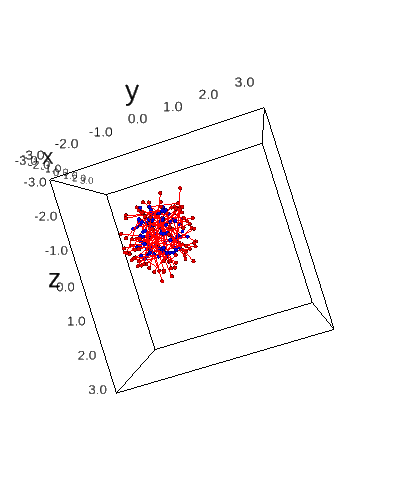

In [56]:
%matplotlib inline
plot_iterations_rotvec(collect_data, angles_true_test, interval=1000, connections=True, selected=range(100))

In [57]:
ipv.screenshot()

Output()

In [58]:
q_predicted.shape

(2000,)

In [59]:
q_predicted = R.from_euler('zyz', angles_predicted).as_quat()

q_predicted_rotated =  update_quaternion(m, a_R, q_predicted, dtype=tf.float64)
angles_predicted_rotated = quaternion2euler(q_predicted_rotated)

In [60]:
from cryoem.plots import plot_pixels_pairs

In [64]:
angles_true_test.shape

(2000, 3)

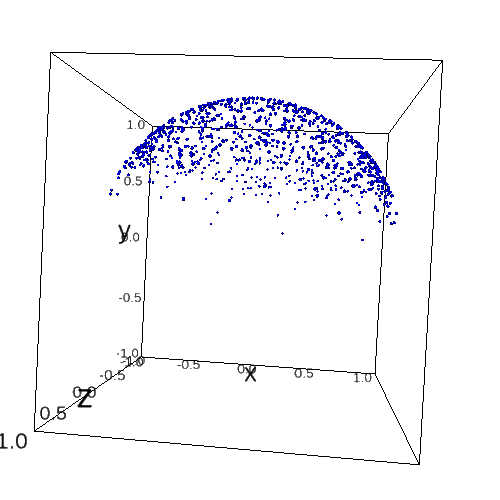

In [65]:
plot_detector_pixels(angles_true_test[:1000])

In [62]:
ipv.screenshot()

Output()

In [66]:
np.save(f"{RESULTS_DIR}/custom_true_angles.npy", angles_predicted_rotated[:1000])

In [64]:
angles_predicted_rotated.shape

TensorShape([2000, 3])

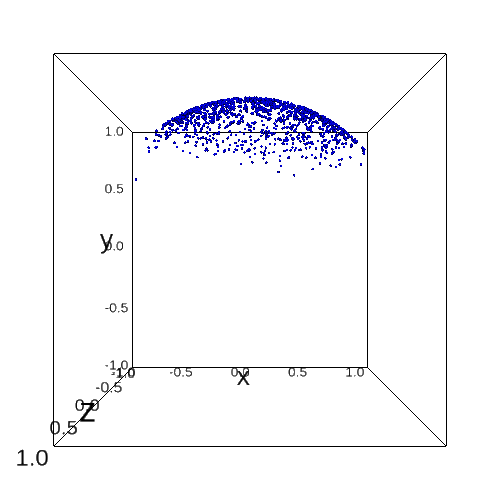

In [70]:
plot_detector_pixels(angles_predicted_rotated[:1000])

In [71]:
ipv.screenshot()

Output()

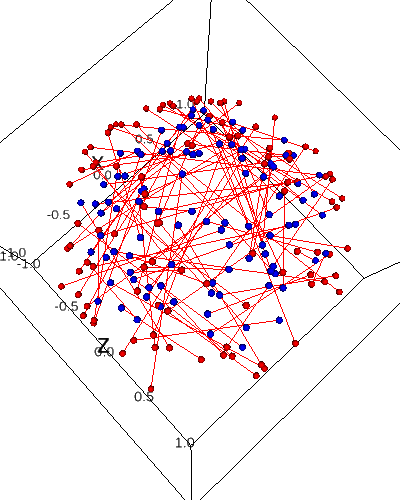

In [68]:
plot_pixels_pairs(angles_true_test, angles_predicted_rotated, interval=1, connections=True, selected=range(100))

In [95]:
ipv.screenshot()

Output()

---

In [ ]:
plot_rotvec(angles_predicted)

In [ ]:
np.array(angles_true_test)

---

In [ ]:
q_predicted_rotated

In [ ]:
euler2quaternion(angles_true)

In [ ]:
from cryoem.plots import plot_rays, plot_iterations_rotvec, plot_rotvec,plot_angles_count, plot_distances_count

In [ ]:
plot_angles_count(np.array(angles_true_test))

In [ ]:
plot_angles_count(angles_predicted.numpy())

In [ ]:
plot_angles_count(angles_predicted_rotated.numpy())

In [ ]:
# plot_distances_count(angles_predicted_rotated.numpy(), angles_true_test)

In [ ]:
np.array(angles_true_test)[:3]

In [ ]:
angles_predicted_rotated.numpy()[:3]

In [ ]:
plot_rotvec(np.array(angles_true_test))

In [ ]:
from scipy.spatial.transform import Rotation as R

In [ ]:
e1 = R.from_euler('zyz', angles_true_test)
rv1 = e1.as_rotvec()
#print(e1)

rv1[:,0] = np.abs(rv1[:,0])
rv1[:,1] = np.abs(rv1[:,1])
rv1[:,2] = np.abs(rv1[:,2])
# rv1_new = np.empty(rv1.shape)
# r = 1.0
# rv1_new[:,0] = -rv1[:,0]
# rv1_new[:,1] = -r*(np.sin(rv1[:,2]))#+(np.sin(rv1[:,1]))
# rv1_new[:,2] = -r*(np.cos(rv1[:,2]))#+(np.cos(rv1[:,1]))

# print()
e1 = R.from_rotvec(rv1).as_euler('zyz')
# print(e1)

In [ ]:
plot_rotvec(e1)

In [ ]:
plot_angles_count(e1)

In [ ]:
import matplotlib.pyplot as plt
import ipyvolume as ipv
from cryoem.rotation_matrices import RotationMatrix
from scipy.spatial.transform import Rotation as R
import numpy as np
import tensorflow as tf
import seaborn as sns; sns.set(style="white", color_codes=True)
import pandas as pd
from matplotlib._png import read_png
from cryoem.conversions import euler2quaternion, d_q


In [ ]:
def plot_pixels_pairs(_angles_true, _angles_pred, interval=1, connections=True, selected=None):
    if not selected:
        selected = range(len(_angles_true))

    if isinstance(_angles_true[0], tf.Variable):
        _angles_true = np.array([a.numpy() for a in _angles_true])
    if isinstance(_angles_pred[0], tf.Variable):
        _angles_pred = np.array([a.numpy() for a in _angles_pred])

    arrt = np.take(RotationMatrix(_angles_true), selected, axis=0)
    arrp = np.take(RotationMatrix(_angles_pred), selected, axis=0)

    ipv.figure(width=500, height=500)
    #ipv.scatter(arrt[:,0], arrt[:,1], arrt[:,2], marker="sphere", color="red", size=1)
    #ipv.scatter(arrp[:,0], arrp[:,1], arrp[:,2], marker="sphere", color="blue", size=1)

    N = len(selected)
    steps = len(arrt)
    x = np.zeros((steps, 2*N))
    y = np.zeros((steps, 2*N))
    z = np.zeros((steps, 2*N))

    for i in range(0, steps):
        x[i] = np.concatenate([arrt[:,0], arrp[:,0]])
        y[i] = np.concatenate([arrt[:,1], arrp[:,1]])
        z[i] = np.concatenate([arrt[:,2], arrp[:,2]])

    ipv.figure()
    lines = [[i, i+N] for i in range(N)]

    if connections:
        s = ipv.scatter(arrp[:,0], arrp[:,1], arrp[:,2], color="blue", marker="sphere")
        ipv.scatter(arrt[:,0], arrt[:,1], arrt[:,2], marker="sphere", color="red", size=2)
        p = ipv.plot_trisurf(x, y, z, lines=lines);
        ipv.animation_control([s, p], interval=interval)
    else:
        s = ipv.scatter(xyz[:,:,0], xyz[:,:,1], xyz[:,:,2], color="blue", marker="sphere")
        ipv.scatter(xyz_true[:,0], xyz_true[:,1], xyz_true[:,2], marker="sphere", color="red", size=2)
        ipv.animation_control(s, interval=interval)

    ipv.xlim(-1,1);ipv.ylim(-1,1);ipv.zlim(-1,1)
    ipv.show()

In [ ]:
_angles_true = np.array(angles_true_test)
_angles_pred = angles_predicted_rotated.numpy()

In [ ]:
plot_pixels_pairs(_angles_true, _angles_pred, interval=1, connections=True, selected=None)

In [ ]:
from cryoem.plots import plot_selected_angles_with_3rd_angle_magnitude

In [ ]:
plot_selected_angles_with_3rd_angle_magnitude(_angles_pred, _angles_true, range(100))

In [ ]:
plot_detector_pixels(_angles_true)

In [ ]:
plot_detector_pixels(angles_predicted_rotated.numpy())

In [ ]:
e1

In [ ]:
from scipy.spatial.transform import Rotation as R

In [ ]:
e1 = R.from_euler('zyz', angles_true_test)
rv1 = e1.as_rotvec()
#print(e1)

rv1_new = np.empty(rv1.shape)
r = 1.0
rv1_new[:,0] = -rv1[:,0]
rv1_new[:,1] = -r*(np.sin(rv1[:,2]))#+(np.sin(rv1[:,1]))
rv1_new[:,2] = -r*(np.cos(rv1[:,2]))#+(np.cos(rv1[:,1]))

print()
e1 = R.from_rotvec(rv1_new).as_euler('zyz')
print(e1)

In [ ]:
plot_iterations_rotvec(collect_data, e1, interval=1000, connections=False, selected=None)

In [ ]:
rv1 = R.from_rotvec([[0,       0, -np.pi ], 
                     [np.pi/2, 0, np.pi/2]])
e1 = rv1.as_euler('zyz')
print(e1)

#rv1_new = np.empty(rv1.shape)
#r = 2.0
#rv1_new[:,0] = -rv1[:,0]
#rv1_new[:,1] = -r*(np.sin(rv1[:,2]))+(np.sin(rv1[:,1]))
#rv1_new[:,2] = -r*(np.cos(rv1[:,2]))+(np.cos(rv1[:,1]))

print()
e1 = R.from_euler('zyz', e1).as_rotvec()
print(e1)

In [ ]:
e1 = R.from_euler('xyz', [[0, 0, -np.pi], [np.pi, np.pi, 0]])
rv1 = e1.as_rotvec()
print(rv1)

#rv1_new = np.empty(rv1.shape)
#r = 2.0
#rv1_new[:,0] = -rv1[:,0]
#rv1_new[:,1] = -r*(np.sin(rv1[:,2]))+(np.sin(rv1[:,1]))
#rv1_new[:,2] = -r*(np.cos(rv1[:,2]))+(np.cos(rv1[:,1]))

e1 = R.from_rotvec(rv1).as_euler('xyz')
print(e1)

In [ ]:
np.min(angles_true_test, axis=0)

In [ ]:
np.min(angles_predicted, axis=0)

In [ ]:
np.max(angles_true_test, axis=0)

In [ ]:
np.max(angles_predicted, axis=0)

In [ ]:
e2 = R.from_euler('zyz', angles_true_test)
rv2 = e2.as_rotvec()

In [ ]:
e1 = R.from_euler('zyz', angles_true_test)
rv1 = e1.as_rotvec()

rv1_new = np.empty(rv1.shape)
r = 2.0
rv1_new[:,0] = -rv1[:,0]
rv1_new[:,1] = -r*(np.sin(rv1[:,2]))+(np.sin(rv1[:,1]))
rv1_new[:,2] = -r*(np.cos(rv1[:,2]))+(np.cos(rv1[:,1]))

e1 = R.from_rotvec(rv1_new).as_euler('zyz')

In [ ]:
plot_rotvec(e1)

---

In [ ]:
plot_rotvec(angles_predicted)

In [ ]:
%matplotlib inline
plot_rotvec(angles_true_test)

In [ ]:
trajectory.shape

## (6) Reconstruction

In [48]:
REC_LOGS_DIR = f"{RESULTS_DIR}/reconstruction"
REC_DESCRIPTION = "full_pipeline_test.mrc"

In [49]:
angles_predicted

array([[ 3.01767038,  0.35601074, -1.55444131],
       [ 2.38470664,  0.59245771, -1.25692055],
       [ 0.43371801,  1.00879092,  0.85191517],
       ...,
       [-1.99060771,  0.2281117 , -2.6935224 ],
       [ 0.70506228,  1.08614131,  0.83260053],
       [ 0.95227773,  1.04104147,  0.66584491]])

In [50]:
angles_predicted_rotated

<tf.Tensor: id=4500091, shape=(1000, 3), dtype=float64, numpy=
array([[ 0.09361124,  1.25190199,  1.14753712],
       [-0.00571688,  0.90213424,  0.91725281],
       [ 1.47835235,  1.28619908,  0.4981998 ],
       ...,
       [ 0.32782798,  1.52989722,  1.19847322],
       [ 1.58960803,  1.05840756,  0.56623743],
       [ 1.51813301,  0.84461452,  0.56641742]])>

In [51]:
angles_true

array([[1.4863281 , 0.9716797 , 0.83203125],
       [1.4619141 , 0.30078125, 0.10150146],
       [0.9482422 , 0.8808594 , 1.0332031 ],
       ...,
       [0.21289062, 1.0810547 , 1.4101562 ],
       [0.59814453, 1.2207031 , 0.56103516],
       [0.9472656 , 0.06774902, 0.2758789 ]], dtype=float32)

In [52]:
import numpy as np
from os import mkdir
from os.path import join, isdir
from imageio import imread, imwrite
from cryoem.rotation_matrices import RotationMatrix
import astra
import mrcfile
from pathlib import Path

def reconstruct(projections, angles, mrc_filename=None, overwrite=False):
    # Generate orientation vectors based on angles
    orientation_vectors   = RotationMatrix(angles)

    # Reshape projections correctly 
    projections1 = np.transpose(projections, (1, 0, 2))
    
    # Get projection dimension
    proj_size = projections1.shape[0]

    # Create projection 2D geometry in ASTRA
    proj_geom = astra.create_proj_geom('parallel3d_vec', proj_size, proj_size, orientation_vectors)
    #proj_geom = astra.create_proj_geom('parallel3d', 0.5, 0.5, proj_size, proj_size, orientation_vectors)
    projections_id = astra.data3d.create('-sino', proj_geom, projections1)

    # Create reconstruction.
    vol_geom = astra.creators.create_vol_geom(proj_size, proj_size, proj_size)
    reconstruction_id = astra.data3d.create('-vol', vol_geom, data=0)
    alg_cfg = astra.astra_dict('BP3D_CUDA')
    alg_cfg['ProjectionDataId'] = projections_id
    alg_cfg['ReconstructionDataId'] = reconstruction_id
    algorithm_id = astra.algorithm.create(alg_cfg)
    astra.algorithm.run(algorithm_id)
    reconstruction = astra.data3d.get(reconstruction_id)


    # Limit and scale reconstruction.
    reconstruction[reconstruction < 0] = 0
    reconstruction /= np.max(reconstruction)
    reconstruction = np.round(reconstruction * 255).astype(np.uint8)

    # Cleanup.
    astra.algorithm.delete(algorithm_id)
    astra.data3d.delete(reconstruction_id)
    astra.data3d.delete(projections_id)


    # Save reconstruction to mrc file for chimera
    if mrc_filename:
        Path(mrc_filename).parent.mkdir(parents=True, exist_ok=True)
        with mrcfile.new(mrc_filename, overwrite=overwrite) as mrc:
            mrc.set_data(reconstruction)
        
    return reconstruction

def reconstruct_from_file(input_file, limit=3000, mrc_filename=None):
    data = np.load(f'data/{input_file}.npz')
    projections, angles = data["arr_0"].astype(np.float64)[:limit, :, :], data["arr_1"].astype(np.float64)[:limit, :]

    return reconstruct(projections, angles, mrc_filename)


In [43]:
projections_test_original = np.empty((len(PROTEINS_TEST)*PROJECTIONS_NUM_SINGLE, IMG_DIM, IMG_DIM, CHANNELS), dtype=DTYPE)
angles_true_test = np.empty((len(PROTEINS_TEST)*PROJECTIONS_NUM_SINGLE, 3), dtype=DTYPE)

print(f"\n* Test dataset *")
for i, protein in enumerate(PROTEINS_TEST):
    data = h5py.File(f"{RESULTS_DIR}/{protein}_ProjectionsAngles_ProjNber{PROJECTIONS_NUM_SINGLE}_AngCoverage{','.join(map(str, ANGLE_COVERAGE))}_AngShift{','.join(map(str, ANGLE_COVERAGE))}.h5", 'r')
    projections = np.array(data['Projections'], dtype=np.float32)
    print(np.min(projections) - np.max(projections))
    if np.isnan(projections).any() or (np.min(projections) - np.max(projections) == 0): 
        PROTEINS_TEST.remove(protein)
        continue
    angles_true = np.array(data['Angles'], dtype=np.float32)
    if np.isnan(angles_true).any() or (np.min(angles_true) - np.max(angles_true) == 0): 
        PROTEINS_TEST.remove(protein)
        continue
    
    print(f"--- protein: {protein} ---")
    print(f"{projections.shape[0]} projections of images with dimension {projections.shape[1:]} pixels")
    print(f"{angles_true.shape[0]} sets of {angles_true.shape[1]} ground truth rotation angles (Z-Y-Z axes) of corresponding projection images")
    
    projections = preprocessing(projections, rescale_dim=IMG_DIM, noise_var_scale=NOISE_VAR_SCALE, left_limit=-TRANSLATION, peak_limit=0, right_limit=TRANSLATION, channels=CHANNELS)
    
    projections_test_original[i*PROJECTIONS_NUM_SINGLE:(i+1)*PROJECTIONS_NUM_SINGLE] = projections.astype(DTYPE)
    angles_true_test[i*PROJECTIONS_NUM_SINGLE:(i+1)*PROJECTIONS_NUM_SINGLE] = angles_true.astype(DTYPE)


* Test dataset *
-307.25
--- protein: 4bed ---
1000 projections of images with dimension (907, 907) pixels
1000 sets of 3 ground truth rotation angles (Z-Y-Z axes) of corresponding projection images
Preprocessing projections
	Image rescaled: 
		from dimension 907 to 64
	Global standardization
		Image shape: (64, 64)
		Data Type: float64
		Mean: 1.743 | Std: 11.045
		Min:  0.000 | Max: 155.522
		Mean: -0.000 | Std: 1.000
		Min:  -0.158 | Max: 13.922
	Noise:
		No noise
	Translation:
		No translation


In [53]:
projections_test_original.shape

(1000, 64, 64, 1)

In [55]:
reconstruction_pred = reconstruct(np.squeeze(projections_test_original)[:500], angles_predicted[:500], mrc_filename='test_protein.mrc', overwrite=True)
reconstruction_pred = reconstruction_pred.astype(np.float)

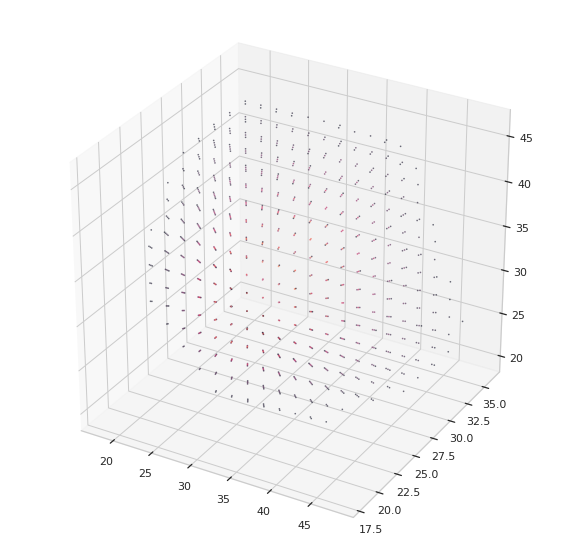

In [56]:
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
step = 2

volume = reconstruction_pred 
volume[volume<50.] = np.nan

x = np.arange(volume.shape[0])[::step, None, None]
y = np.arange(volume.shape[1])[None, ::step, None]
z = np.arange(volume.shape[2])[None, None, ::step]
x, y, z = np.broadcast_arrays(x, y, z)
c = volume[::step,::step,::step].ravel()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')
ax.scatter(x.ravel(),
           y.ravel(),
           z.ravel(), alpha=0.5, s=0.5,
           c=c)

In [60]:
reconstruction = reconstruct(np.squeeze(projections_test_original)[:500], angles_predicted_rotated[:500], mrc_filename=f"{REC_LOGS_DIR}/{REC_DESCRIPTION}", overwrite=True)
reconstruction = reconstruction.astype(np.float)

In [61]:
reconstruction_true = reconstruct(np.squeeze(projections_test_original)[:500], angles_true[:500], mrc_filename=False, overwrite=False)
reconstruction_true = reconstruction_true.astype(np.float)

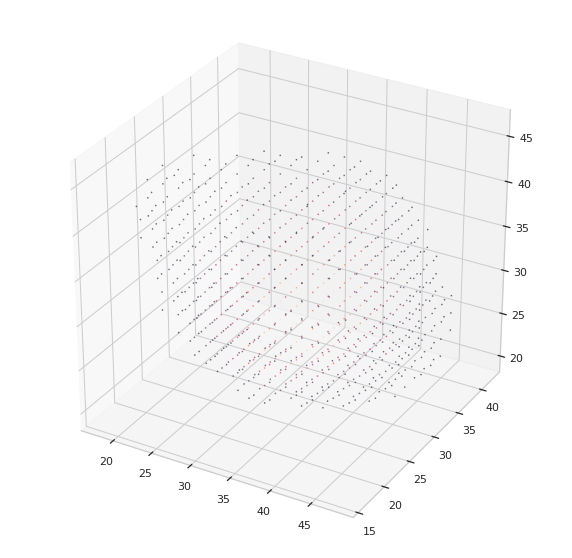

In [62]:
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
step = 2

volume = reconstruction 
volume[volume<50.] = np.nan

x = np.arange(volume.shape[0])[::step, None, None]
y = np.arange(volume.shape[1])[None, ::step, None]
z = np.arange(volume.shape[2])[None, None, ::step]
x, y, z = np.broadcast_arrays(x, y, z)
c = volume[::step,::step,::step].ravel()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')
ax.scatter(x.ravel(),
           y.ravel(),
           z.ravel(), alpha=0.5, s=0.5,
           c=c)

volume_true = reconstruction_true 
volume_true[volume_true<70.] = np.nan

x_t = np.arange(volume_true.shape[0])[::step, None, None]
y_t = np.arange(volume_true.shape[1])[None, ::step, None]
z_t = np.arange(volume_true.shape[2])[None, None, ::step]
x_t, y_t, z_t = np.broadcast_arrays(x_t, y_t, z_t)
c_t = volume_true[::step,::step,::step].ravel()

#fig = plt.figure(figsize = (10, 10))
#ax = fig.gca(projection='3d')
# ax.scatter(x_t.ravel(),
#            y_t.ravel(),
#            z_t.ravel(), alpha=0.5, s=0.5,
#            c=c_t)

/home/jelena/miniconda3/envs/protein_reconstruction/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


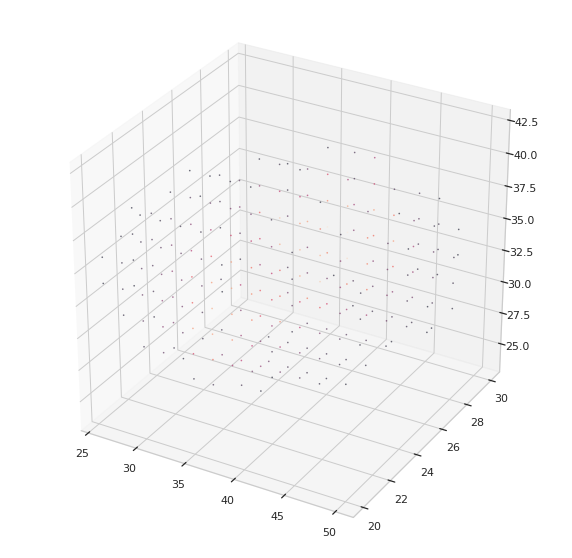

In [63]:
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
step = 2

volume_true = reconstruction_true 
volume_true[volume_true<50.] = np.nan

x_t = np.arange(volume_true.shape[0])[::step, None, None]
y_t = np.arange(volume_true.shape[1])[None, ::step, None]
z_t = np.arange(volume_true.shape[2])[None, None, ::step]
x_t, y_t, z_t = np.broadcast_arrays(x_t, y_t, z_t)
c_t = volume_true[::step,::step,::step].ravel()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')
ax.scatter(x_t.ravel(),
           y_t.ravel(),
           z_t.ravel(), alpha=0.5, s=0.5,
           c=c_t)

In [ ]:
%matplotlib inline
plt.hist(reconstruction.ravel()-reconstruction_true.ravel());
plt.show()

In [ ]:
reconstruction.ravel()[~np.isnan(reconstruction.ravel())]

In [ ]:
reconstruction_true.ravel()[~np.isnan(reconstruction_true.ravel())]

In [ ]:
volume_true.ravel()[~np.isnan(volume_true.ravel())]

In [ ]:
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
step = 2

volume_true = reconstruction_true - reconstruction
#volume_true[volume_true<50.] = np.nan

x_t = np.arange(volume_true.shape[0])[::step, None, None]
y_t = np.arange(volume_true.shape[1])[None, ::step, None]
z_t = np.arange(volume_true.shape[2])[None, None, ::step]
x_t, y_t, z_t = np.broadcast_arrays(x_t, y_t, z_t)
c_t = volume_true[::step,::step,::step].ravel()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')
ax.scatter(x_t.ravel(),
           y_t.ravel(),
           z_t.ravel(), alpha=0.5, s=0.5,
           c=c_t)

In [ ]:
volume_true = reconstruction_true - reconstruction

In [ ]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(reconstruction_true.ravel(), reconstruction.ravel())
#np.mean_square_error(volume_true.ravel()[~np.isnan(volume_true.ravel())])
mse